In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import tensorflow as tf
import cv2
from skimage import io
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [2]:
def load_data(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])
    
    matched_images, matched_labels = [], []

    for img_file in image_files:
        label_file = img_file.replace('.tif', '.png')
        if label_file in label_files:
            matched_images.append(os.path.join(image_dir, img_file))
            matched_labels.append(os.path.join(label_dir, label_file))
        else:
            print(f"Warning: No matching label for {img_file}")
    
    images = np.array([tiff.imread(f)[:, :, :3] for f in matched_images])  # Ensure 3 channels
    labels = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in matched_labels])

    images = images / 255.0  # Normalize images
    labels = (labels > 0.5).astype(np.uint8)  # Convert labels to binary mask

    if labels.ndim == 3:  # Ensure labels have a channel dimension
        labels = np.expand_dims(labels, axis=-1)
    
    return images, labels


In [3]:
def display_image_and_mask(img_path, mask_path):
    img = io.imread(img_path)  # Load TIFF image
    
    # Convert multi-channel image to RGB (Keep first 3 channels)
    if len(img.shape) == 3 and img.shape[-1] > 3:
        img = img[:, :, :3]  # Select the first 3 channels

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Load mask

    # Convert mask to grayscale if needed
    if mask is not None and len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Display the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.show()

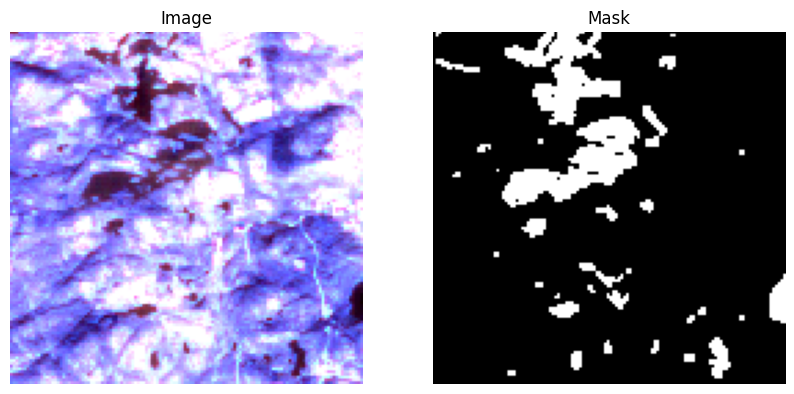

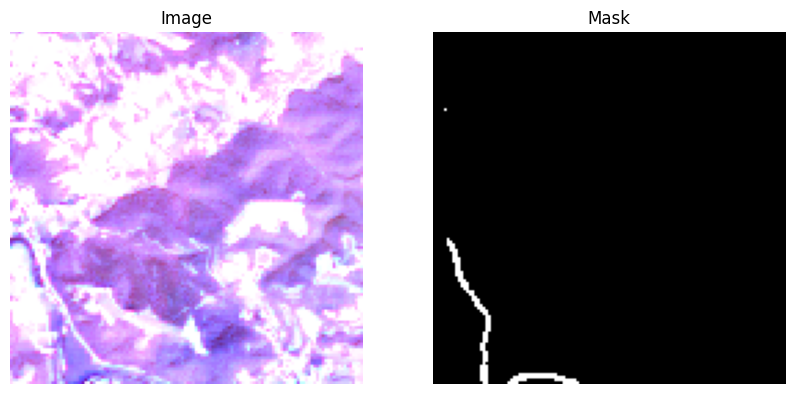

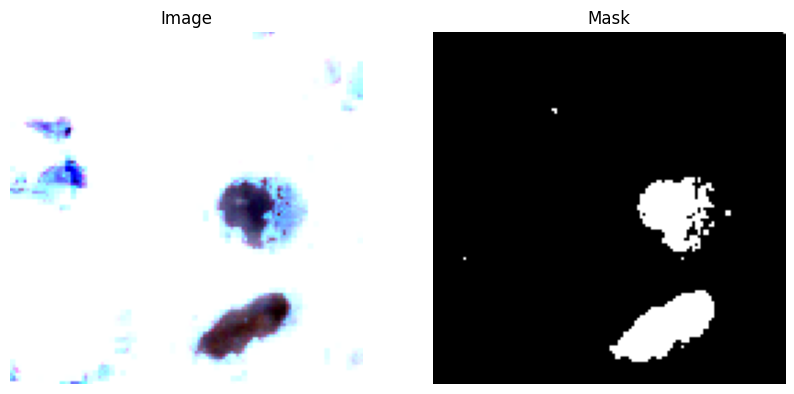

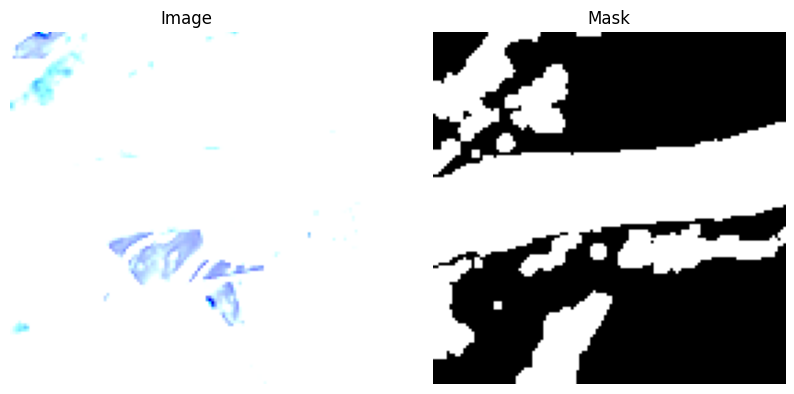

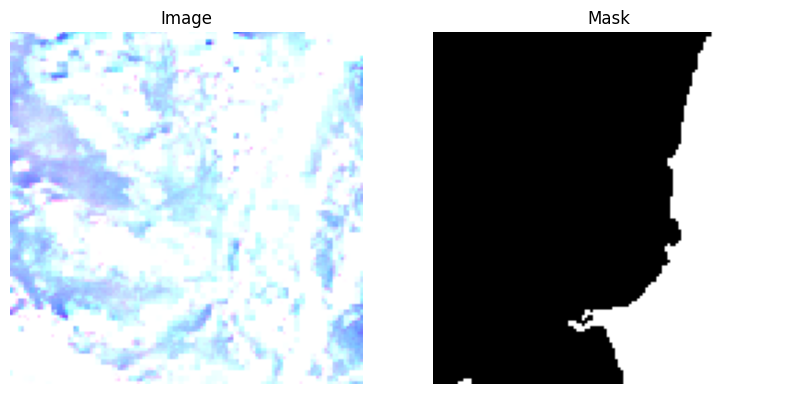

In [4]:
train_img_dir = "/kaggle/input/water-segmentation/data/images"
train_mask_dir = "/kaggle/input/water-segmentation/data/labels"

train_img_files = sorted(os.listdir(train_img_dir))
train_mask_files = sorted(os.listdir(train_mask_dir))

for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)
    display_image_and_mask(img_path, mask_path)

In [5]:
# Data Generator Class
class ImageLabelGenerator(Sequence):
    def __init__(self, images, labels, batch_size, augmentations):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.indexes = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        
        if self.augmentations:
            batch_images, batch_labels = next(self.augmentations.flow(batch_images, batch_labels, batch_size=self.batch_size))
        
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)



In [6]:
# Data Augmentation
image_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
label_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')

image_dir = "/kaggle/input/water-segmentation/data/images"
label_dir = "/kaggle/input/water-segmentation/data/labels"
images, labels = load_data(image_dir, label_dir)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.applications import EfficientNetB0
def unet_efficientnet(input_size=(128, 128, 3)):
    base_model = EfficientNetB0(include_top=False, input_tensor=layers.Input(shape=input_size), weights="imagenet")
    
    # Encoder (Pretrained Layers)
    c1 = base_model.get_layer('block2a_expand_activation').output  # (64x64x32)
    c2 = base_model.get_layer('block3a_expand_activation').output  # (32x32x48)
    c3 = base_model.get_layer('block4a_expand_activation').output  # (16x16x80)
    c4 = base_model.get_layer('block6a_expand_activation').output  # (8x8x192)
    
    bottleneck = base_model.get_layer('top_activation').output  # (4x4x1280)
    
    # Decoder
    u6 = layers.Conv2DTranspose(192, (2, 2), strides=(2, 2), padding='same')(bottleneck)  
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(192, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.3)(c6)  # Dropout to prevent overfitting

    u7 = layers.Conv2DTranspose(112, (2, 2), strides=(2, 2), padding='same')(c6)
    c3_resized = layers.Conv2D(80, (1, 1), activation='relu', padding='same')(c3)  
    u7 = layers.concatenate([u7, c3_resized])  
    c7 = layers.Conv2D(112, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Dropout(0.3)(c7)

    u8 = layers.Conv2DTranspose(48, (2, 2), strides=(2, 2), padding='same')(c7)
    c2_resized = layers.Conv2D(48, (1, 1), activation='relu', padding='same')(c2)  
    u8 = layers.concatenate([u8, c2_resized])  
    c8 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    c1_resized = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(c1)  
    u9 = layers.concatenate([u9, c1_resized])  
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)

    u10 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u10)
    
    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [9]:
# Create data generators
train_generator = ImageLabelGenerator(X_train, y_train, batch_size=16, augmentations=image_datagen)
val_generator = ImageLabelGenerator(X_test, y_test, batch_size=16, augmentations=None)

sample_batch = next(iter(train_generator))
print("Train Batch Image Shape:", sample_batch[0].shape)  
print("Train Batch Mask Shape:", sample_batch[1].shape)  

Train Batch Image Shape: (16, 128, 128, 3)
Train Batch Mask Shape: (16, 128, 128, 1)


In [10]:
# Train Model
model = unet_efficientnet()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 6,928,756 (26.43 MB)

 Trainable params: 6,885,965 (26.27 MB)

 Non-trainable params: 42,791 (167.16 KB)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5895 - loss: 0.6739 - val_accuracy: 0.4985 - val_loss: 0.7261
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6268 - loss: 0.6561 - val_accuracy: 0.5015 - val_loss: 0.6954
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6642 - loss: 0.6382 - val_accuracy: 0.5109 - val_loss: 0.6753
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6996 - loss: 0.6196 - val_accuracy: 0.4474 - val_loss: 0.6887
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7248 - loss: 0.5978 - val_accuracy: 0.4004 - val_loss: 0.7767
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7641 - loss: 0.5528 - val_accuracy: 0.2883 - val_loss: 1.0860
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7904 - loss: 0.4859 - val_accuracy: 0.3219 - val_loss: 1.0380
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8048 - loss: 0.4453 - val_accuracy: 0.4262 - val_loss: 0.8565
Epo

In [13]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(np.uint8)

iou = jaccard_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)
precision = precision_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)
recall = recall_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)
f1 = f1_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)

print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
IoU: 0.5320
Precision: 0.8441
Recall: 0.5899
F1 Score: 0.6945


In [14]:
loss, accuracy = model.evaluate(val_generator, steps=50)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8742 - loss: 0.2791  
Validation Loss: 0.28023990988731384
Validation Accuracy: 0.8735427856445312


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


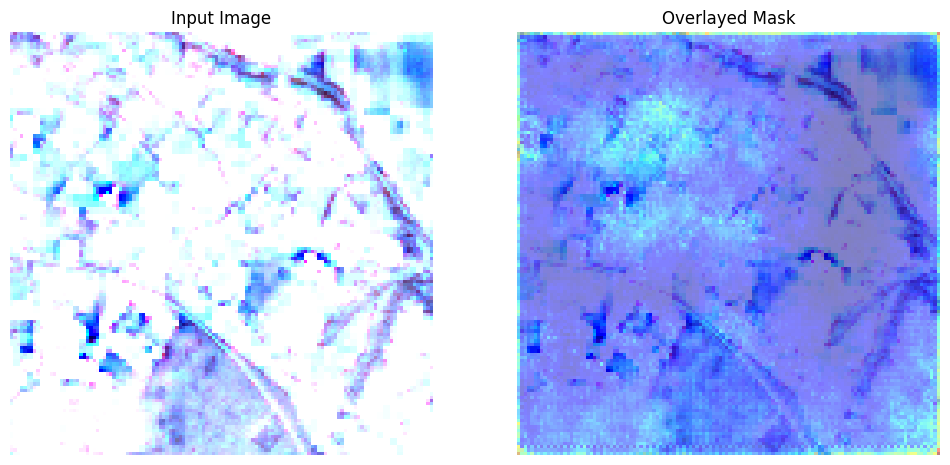

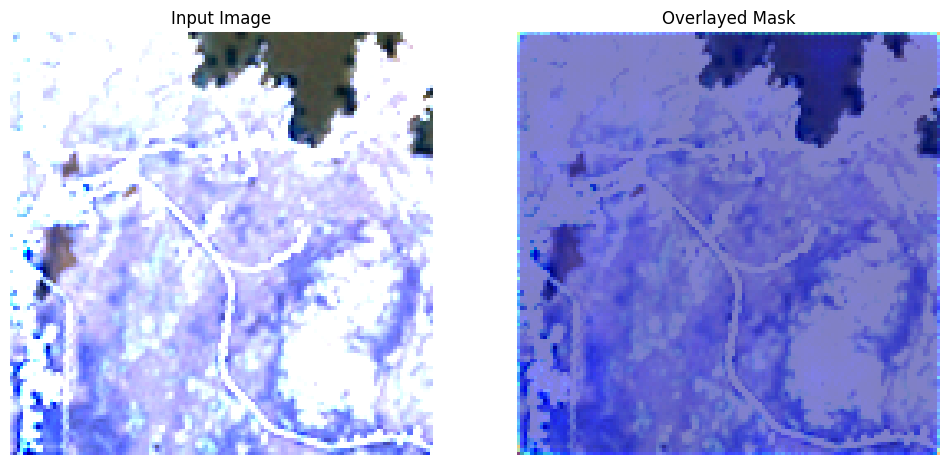

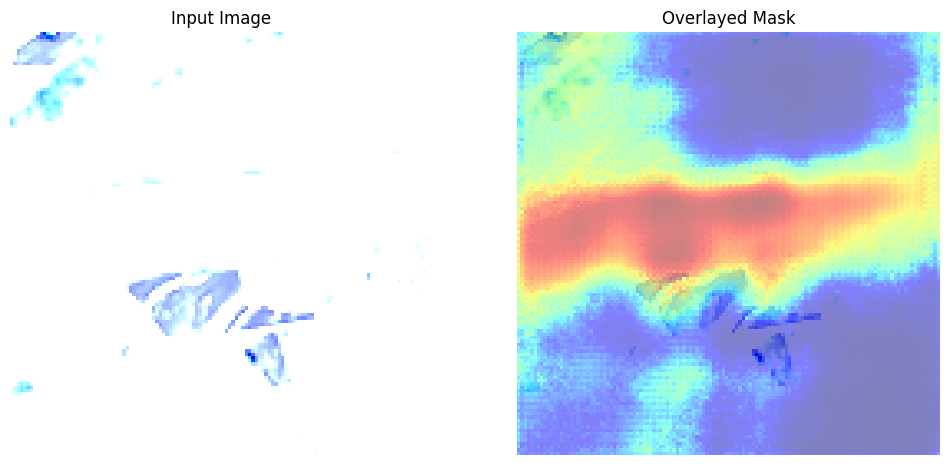

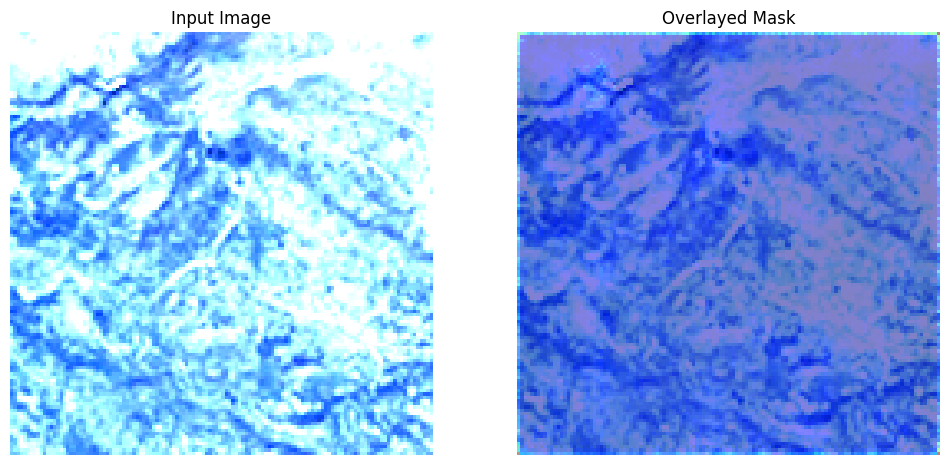

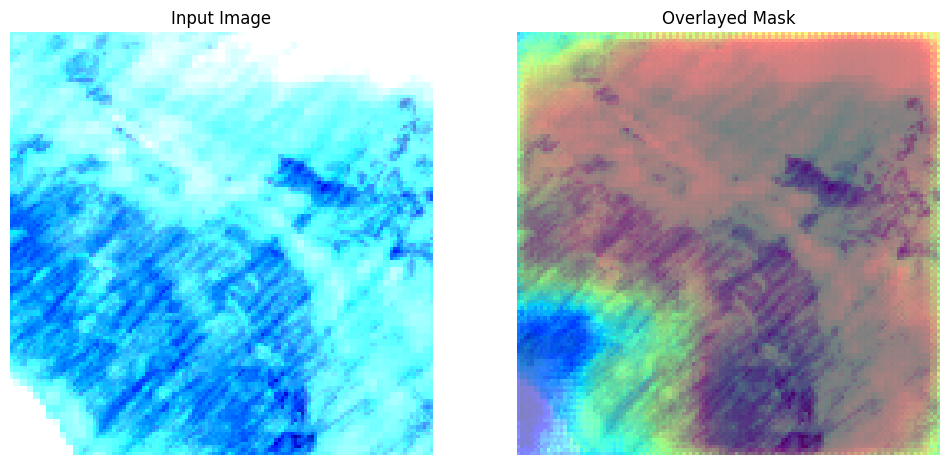

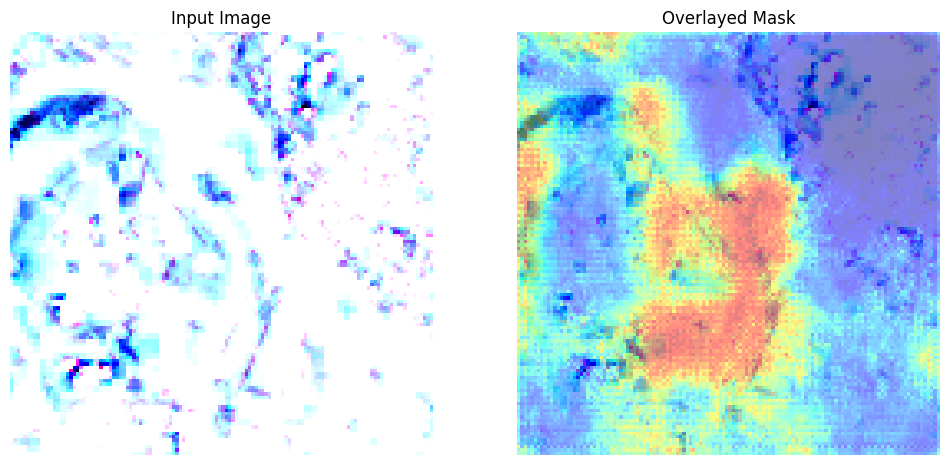

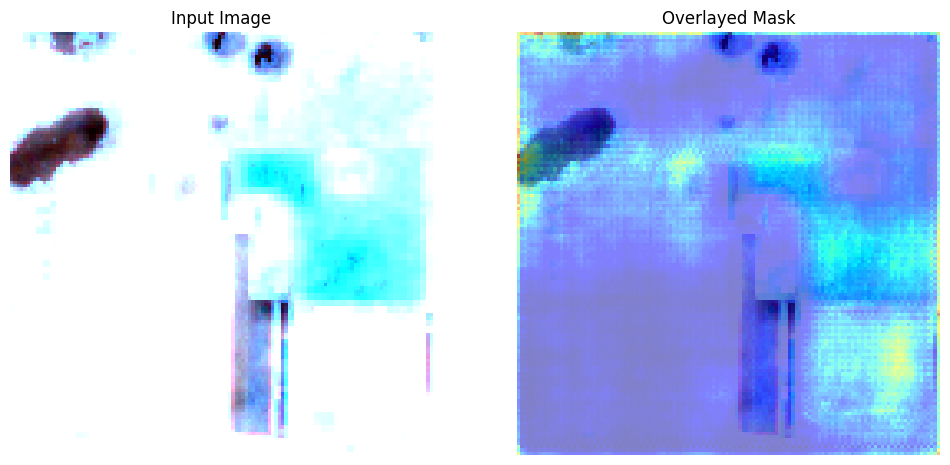

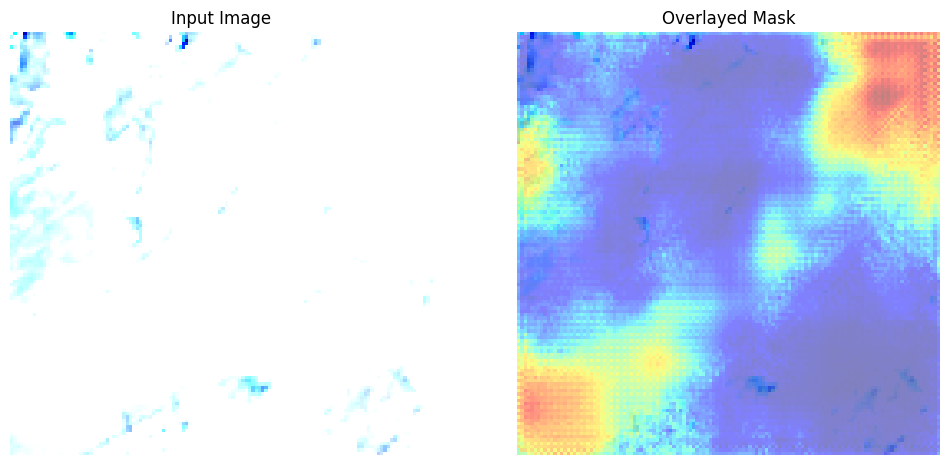

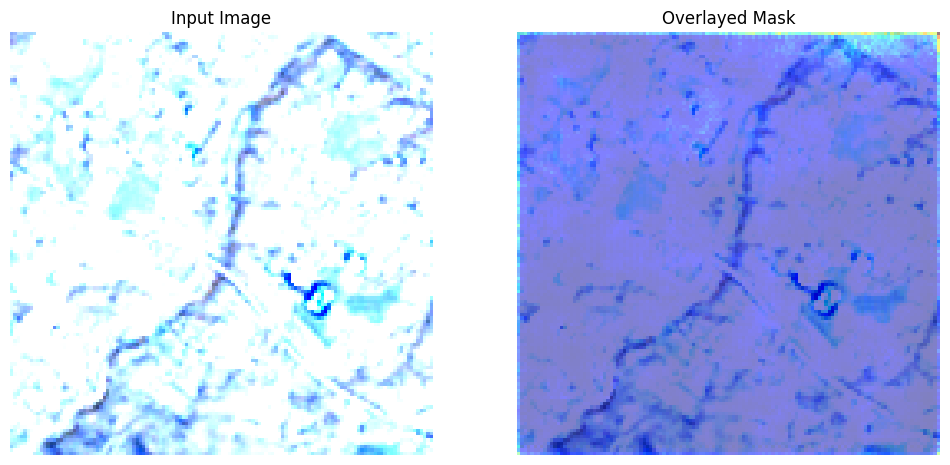

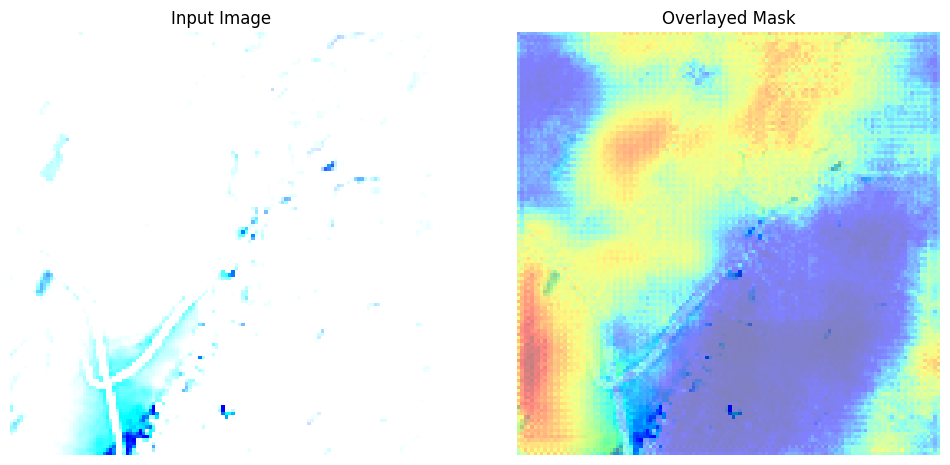

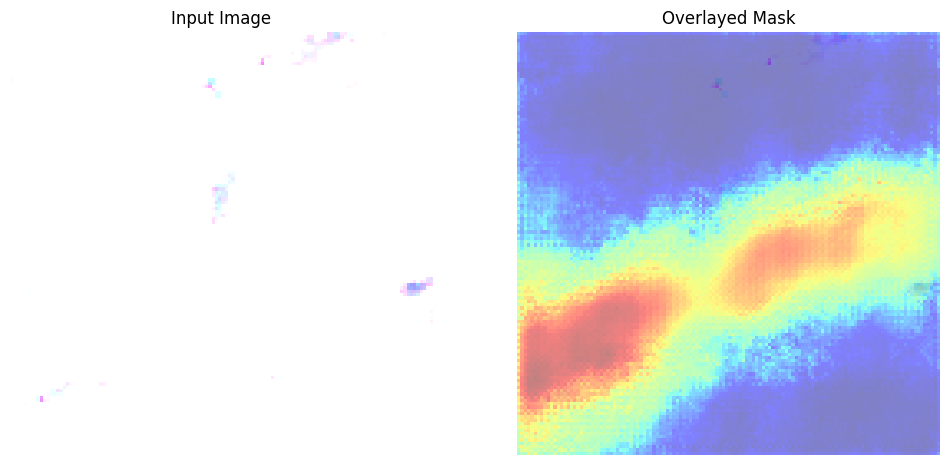

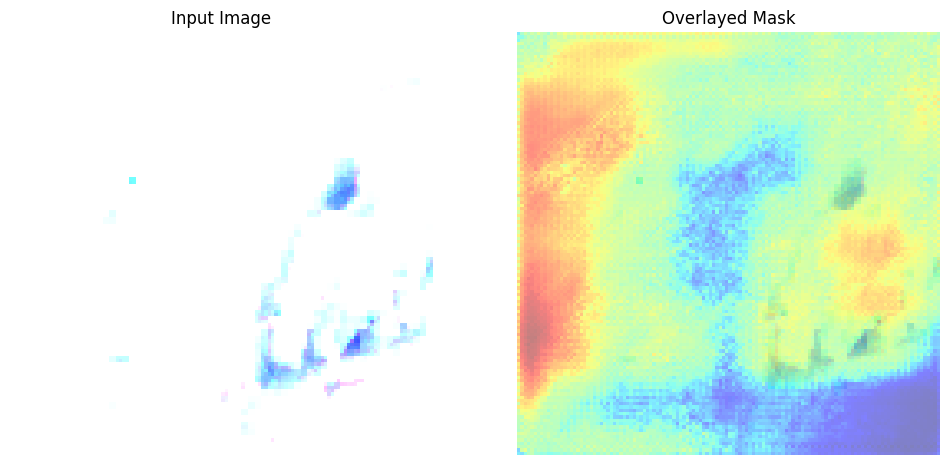

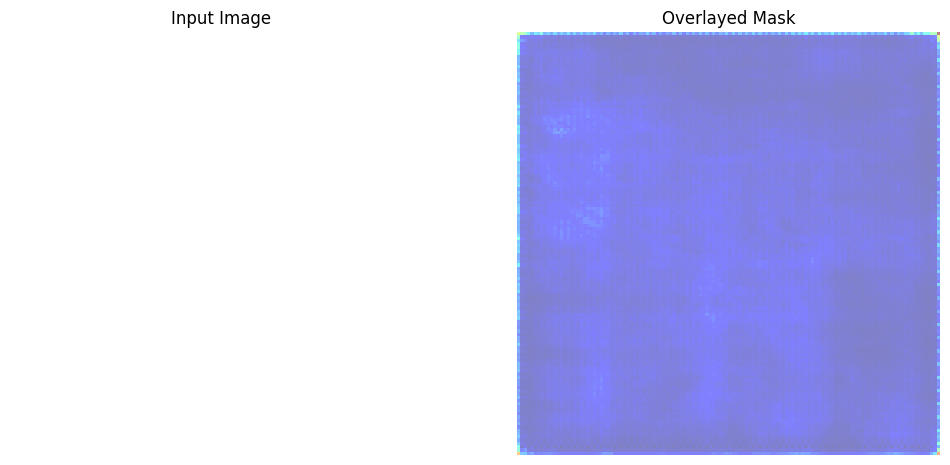

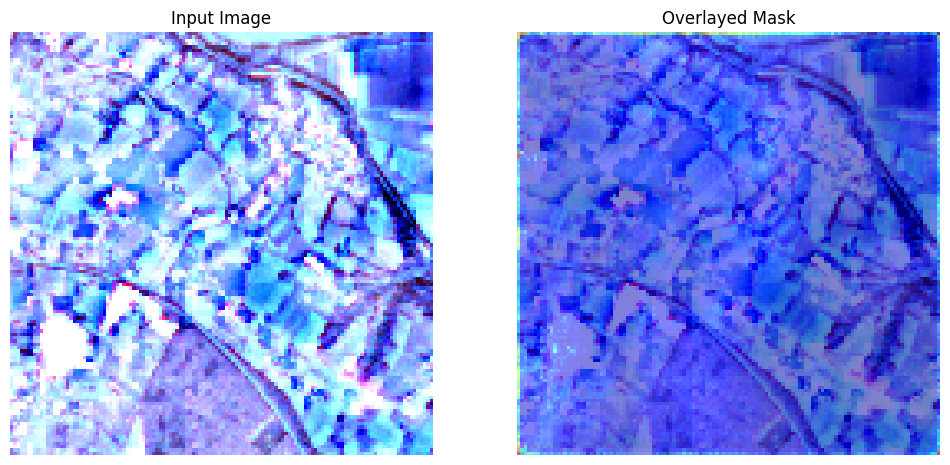

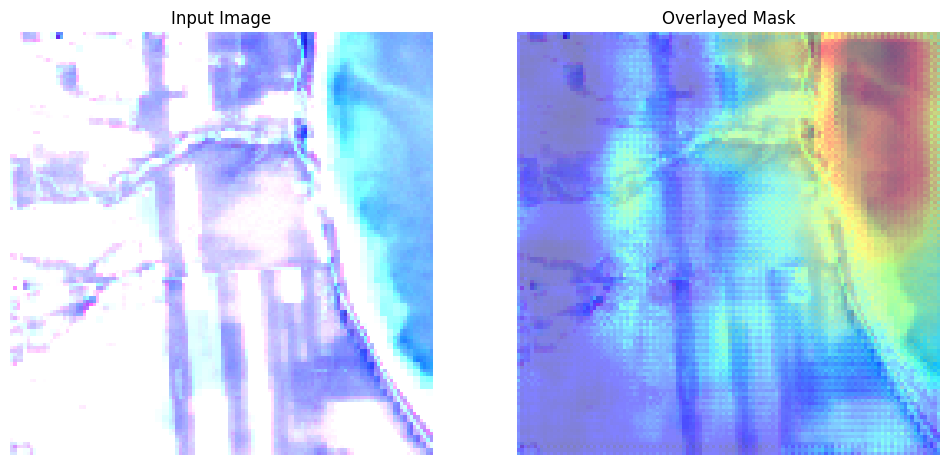

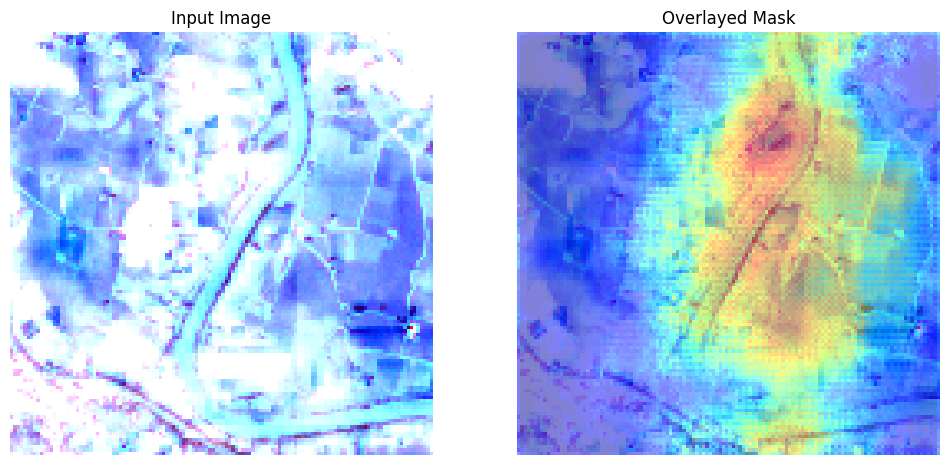

In [15]:
# Overlay Predictions
def overlay_predictions(model, generator, alpha=0.5):
    generator_iter = iter(generator)
    images, masks = next(generator_iter)
    predictions = model.predict(images)

    for i in range(len(images)):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        if images.shape[-1] > 3:
            plt.imshow(images[i, :, :, :3])  # Use first 3 channels as RGB
        else:
            plt.imshow(images[i])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Overlayed Mask")
        if images.shape[-1] > 3:
            plt.imshow(images[i, :, :, :3])
        else:
            plt.imshow(images[i])
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        plt.show()

# Display overlayed predictions
overlay_predictions(model, val_generator)